In [2]:
import numpy as np
import matplotlib.pyplot as plt

class m1m2cc:
    """
    intialisation of state vars, statistical counters and events
    main variation in this code is the use of two arrival streams
    """
    def __init__(self, call_rate, handover_rate, call_duration, channels, iterations, threshold):

        self.call_rate = call_rate
        self.handover_rate = handover_rate
        self.call_duration = call_duration

        self.channels = channels
        self.iterations = iterations
        self.sim_time = 0   
        self.time_of_last_event = float("inf")

        self.total_arrivals = 0
        self.new_call_arrival = 0
        self.handover_arrival = 0
        self.threshold = threshold


        # idx 0 = new call event, idx1 = handover call event
        self.events = [float("inf") for _ in range(self.channels + 2)]
        self.events[0] = self.sim_time + np.random.exponential(1 / self.call_rate) # exponential of interarrival times
        self.events[1] = self.sim_time + np.random.exponential(1 / self.handover_rate) # exponential of interarrival times
        self.server_status = [ 0 for _ in range (self.channels)]
        
        # statistical counters 
        self.server_usage = [ 0 for _ in range (self.channels)]
        self.new_call_bloked = 0
        self.handover_blocked = 0
        self.all_data = []  


    """
    updates simulation clock and finds the next event
    """
    def timing(self):
        next_event_idx = self.events.index(min(self.events))
        self.time_of_last_event = self.sim_time

        # advance clock to next event
        self.sim_time = self.events[next_event_idx]
        return next_event_idx
    

    """
    handles arrival events
        - schedules next arrival
        - assigns job to server if free otherwise increments block counter
    """
    def arrive(self, event_idx):
        # schedule the next arrival
        self.total_arrivals += 1
        self.new_call_arrival += 1 if event_idx == 0 else 0
        self.handover_arrival += 1 if event_idx == 1 else 0

        lamda = self.call_rate if event_idx == 0 else self.handover_rate
        self.events[event_idx] = self.sim_time + np.random.exponential(1 / lamda)

        # find if any server is idle, if so set to busy and schedule departure
        def assign_server():
            for i in range(self.channels):
                if self.server_status[i] == 0:
                    self.server_status[i] = 1
                    self.events[i + 2] = self.sim_time + np.random.exponential(self.call_duration)
                    break

        # check how many servers are free
        num_of_active_servers = self.server_status.count(1)
        free_servers = self.channels - num_of_active_servers
       
        if free_servers == 0:

            self.new_call_bloked += 1 if event_idx == 0 else 0
            self.handover_blocked += 1 if event_idx == 1 else 0

        # else there are some free servers
        else:
            if event_idx == 0:
                if free_servers > self.threshold:
                    assign_server()
                else:
                    self.new_call_bloked += 1
            else:
                assign_server()

            
    """
    handles departure events by reseting events 
    """
    def departure(self, server_idx):
        # once job is done server becomes idle, (there is no queue to fetch customers from)
        self.server_status[server_idx - 2] = 0
        self.events[server_idx] = float("inf")


    """
    updates statistical counters
        - works by calculating time since past event and incrementing it to a servers usage if busy
    """
    def update_stats(self):
        time_past = self.sim_time - self.time_of_last_event
        for i in range(self.channels):
            self.server_usage[i] += time_past * self.server_status[i]


    """
    returns key metrics we are interested in
        - CBP, call blocking probability
        - HBP, Handover blocking probability
    """
    def report(self):
        # print(self.total_arrivals, self.new_call_arrival,  self.handover_arrival, "\n")
        # print(self.total_arrivals, self.new_call_bloked/self.new_call_arrival,  self.handover_blocked/self.handover_arrival, "\n")
        # print(f"total arrivals : {self.total_arrivals}, NC blocked: {self.new_call_bloked}, HC blocked: {self.handover_blocked}")
        #print(self.handover_blocked, self.handover_arrival, self.new_call_bloked, self.new_call_arrival, "\n")
        return ((self.new_call_bloked/self.new_call_arrival),(self.handover_blocked/self.handover_arrival))


    """
    Exectutes simulation logic
        - terminates after self.iterations seconds
        - generates the report after simulation completed
    """
    def main(self):

        while self.sim_time < self.iterations:
            #print(self.sim_time, self.events, "\n")

            next = self.timing()
            self.update_stats()
            
            if next < 2:
                self.arrive(next) # either handover or new call if idx 0/1
            else:
                self.departure(next)
                
        self.report()

### Find the maximum value for the handover rate so that the Aggregated Blocking Probability (ABP) < 0.02 

In [4]:

"""
this function finds the maximum value for handover rate where ABP < 0.02
Returns: max handover rate
"""
def handover_rate_trial():
 
    call_rate = 0.1
    handover_rate = np.sort(np.random.uniform(0, 0.2, 100))
    call_duration = 100
    servers = 16
    iterations = 100000
    threshold = 2
    minimum = float("-inf")
    abps = []
    cbps = []
    hfps = []


    for i in range(len(handover_rate)):

        obj = m1m2cc(call_rate , handover_rate[i] , call_duration, servers, iterations, threshold)
        obj.main()
        cbp, hfp = obj.report()
        abp = cbp + (10 * hfp)
        if abp < 0.02: 
            minimum = handover_rate[i]

        abps.append(abp)
        cbps.append(cbp)
        hfps.append(hfp)


    print(f"MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : {minimum}")
    return minimum, abps, cbps, hfps, handover_rate


# running num_trials iterations of handover_rate_trial() for more broader testing
num_trials = 10
avg = 0
mx = 0
for i in range(num_trials):
    t, a, c, h, hr = handover_rate_trial()
    avg += t
    mx = max(mx, t)

avg /= num_trials
print(f" MAX SEEN λ : {mx}, AVG MAX: {avg}")
    


MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : -inf
 MAX SEEN λ : 0, AVG MAX: -inf


### Find the maximum value for the new call rate so that the ABP < 0.02 (Note: if such a value doesn’t exist, state the reason)

In [16]:

"""
this function finds the maximum value for handover rate where ABP < 0.02
Returns: max handover rate
"""
def call_rate_trial():
 
    call_rate = np.sort(np.random.uniform(0, 0.1, 100))
    handover_rate = 0.03
    call_duration = 100
    servers = 16
    iterations = 10000
    threshold = 2
    minimum = float("-inf")
    abps = []
    cbps = []
    hfps = []


    for i in range(len(call_rate)):

        obj = m1m2cc(call_rate[i] , handover_rate , call_duration, servers, iterations, threshold)
        obj.main()
        cbp, hfp = obj.report()
        abp = cbp + (10 * hfp)

        if abp < 0.02: 
            minimum = call_rate[i]

        abps.append(abp)
        cbps.append(cbp)
        hfps.append(hfp)
        #print(handover_rate[i], cbp, hfp, abp)


    print(f"MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : {minimum}")
    return minimum, abps, cbps, hfps, call_rate


num_trials = 10
avg = 0
mx = 0
for i in range(num_trials):
    t, a, c, h, hr = call_rate_trial()
    avg += t
    mx = max(mx, t)

avg /= num_trials
print(f" MAX SEEN λ : {mx}, AVG MAX: {avg}")
len(h), len(c), len(a), len(hr)


MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.054420672951870724
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.05895785842795775
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.058391177446740855
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.055872855234515406
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.06901997695063404
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.05564086985752246
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.057930477288475626
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.05768016778116819
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.057024501913195164
MAXIMUM HANDOVER RATE WHERE ABP< 0.02 : 0.05435169416193945
 MAX SEEN λ : 0.06901997695063404, AVG MAX: 0.05792902520140196


(100, 100, 100, 100)

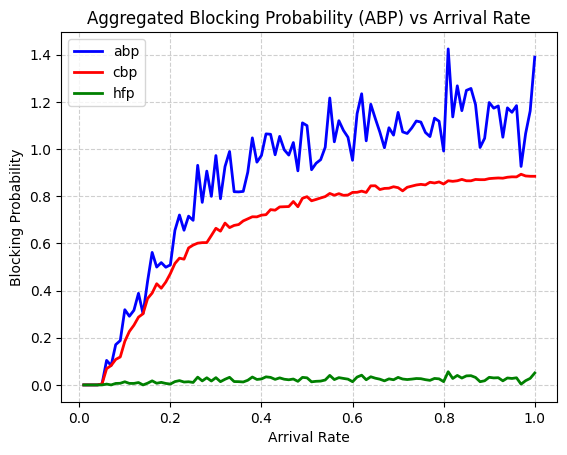

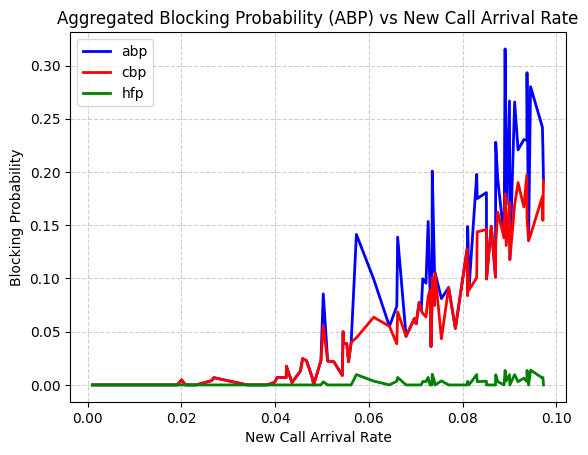

In [17]:
call_rate = [ (i + 1) / 100 for i in range(100)]
#call_rate = hr
handover_rate = 0.03
call_duration = 100
servers = 16
iterations = 10000
threshold = 2
mins = 0

abps = []
cbps = []
hfps = []

for i in range(len(call_rate)):
    obj = m1m2cc(call_rate[i] , handover_rate , call_duration, servers, iterations, threshold)
    obj.main()
    cbp, hfp = obj.report()
    abp = cbp + (10 * hfp)
    abps.append(abp)
    cbps.append(cbp)
    hfps.append(hfp)

    if abp < 0.02: 
        mins = call_rate[i]

def blocking_arrival_plot(data, arrivals, title, x, y):
    plt.figure(1)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

    plt.plot(arrivals, data[0], linestyle='-', color='blue', linewidth=2, label="abp")
    plt.plot(arrivals, data[1], linestyle='-', color='red', linewidth=2, label="cbp")
    plt.plot(arrivals, data[2], linestyle='-', color='green', linewidth=2, label="hfp") # marker='o',
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.show()

# both plots depict the samme info but the second plot has more data points
blocking_arrival_plot([abps, cbps, hfps], call_rate, "Aggregated Blocking Probability (ABP) vs Arrival Rate", "Arrival Rate", 'Blocking Probability')
blocking_arrival_plot([a, c, h], hr, "Aggregated Blocking Probability (ABP) vs New Call Arrival Rate", "New Call Arrival Rate", 'Blocking Probability')

